# **Random Forest Regression**

In [13]:
import numpy as np
import pandas as pd
import datetime

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt

In [14]:
def download_link(url):
  '''Method reformates the share link from Google Drive into fetchable form'''
  return 'https://drive.google.com/uc?id=' + url.split('/')[-2]

**Data preparation**

In [15]:
# Cycling data
cycling_data = pd.read_csv(download_link("https://drive.google.com/file/d/15eHai6zkPwOBMq59n8uIjjohuuiaV8DF/view?usp=sharing"))
cycling_data["DATUM_A_CAS"] = pd.to_datetime(cycling_data["DATUM_A_CAS"], errors="coerce")
cycling_data["DATUM_A_CAS"] = cycling_data["DATUM_A_CAS"].dt.date

In [16]:
cycling_data = cycling_data[["NAZOV", "SMER_DO", "SMER_Z", "DATUM_A_CAS", "POCET_DO", "POCET_Z"]]

aggregated_data = cycling_data.groupby(["NAZOV", "DATUM_A_CAS"], as_index=False).sum(numeric_only=True)
aggregated_data = aggregated_data[aggregated_data["DATUM_A_CAS"] >= datetime.date(2022, 1, 1)]

aggregated_data["POCET"] = aggregated_data["POCET_DO"] + aggregated_data["POCET_Z"]
aggregated_data = aggregated_data[["NAZOV", "DATUM_A_CAS", "POCET"]]

In [17]:
# Weather data
weather_data = pd.read_csv(download_link("https://drive.google.com/file/d/1keTewFIu3ceNYhfNuiLxD9vqlcW5t2S9/view?usp=sharing")).fillna(0)

# Average temperature, Min temperature, Max temperature, Precipitation, Snowing (rarely), Wind speed, Pressure
weather_data = weather_data[["date", "tavg", "tmin", "tmax", "prcp", "snow", "wspd", "pres"]]
weather_data["date"] = pd.to_datetime(weather_data["date"], errors="coerce")
weather_data["date"] = weather_data["date"].dt.date

**Train-Val-Test split**

We have decided to use year wise split of data, avoiding COVID-19 quarantine years before 2022. We perform split based on percentages, because not all data have the same length. In order to take into account data chronology, we use first <code>60 %</code> of data for training, second <code>30 %</code> for validation and remaining <code>10 %</code> for testing purposes.

In [18]:
# Getting all the routes available
routes = list(aggregated_data["NAZOV"].unique())

In [19]:
# Trying Starý most
x = ["tavg", "tmin", "tmax", "prcp", "snow", "wspd", "pres"]
y = ["POCET_DO", "POCET_Z"]

# Random Forest Regressor

In [20]:
mae_rf = {}

for route in routes:
    row = []
    for depth in range(2, 11):
        route_subsample = aggregated_data[aggregated_data["NAZOV"] == route]

        DATA = pd.merge(left=route_subsample, right=weather_data, left_on="DATUM_A_CAS", right_on="date")
        TRAIN = DATA[:int(0.6*len(DATA))]
        VALIDATION = DATA[int(0.6*len(DATA)):int(0.9*len(DATA))]
        TEST = DATA[int(0.9*len(DATA)):int(len(DATA))]
    
        MODEL = RandomForestRegressor(max_depth=depth)

        # Fit & transform training data
        X_train = TRAIN[x]
        y_train = TRAIN[["POCET"]].values.ravel()

        # Train model
        MODEL.fit(X_train, y_train)

        # Transform validation data
        X_val = VALIDATION[x]

        # Predict
        y_pred = MODEL.predict(X_val)

        # Evaluate
        mae = mean_absolute_error(VALIDATION["POCET"], y_pred)

        if route[0] == "#":
            route_name = " ".join(route.split()[2:])
        else:
            route_name = route
    
        print(route_name, 100*mae/np.mean(DATA["POCET"]))
        row.append(100*mae/np.mean(DATA["POCET"]))
    
    mae_rf[route_name] = row.copy()

Starý Most 24.719594013460807
Starý Most 23.908571891693175
Starý Most 23.952209492170326
Starý Most 24.211313720816413
Starý Most 24.419282181375717
Starý Most 25.063442377740248
Starý Most 25.080324259889327
Starý Most 25.775201911466578
Starý Most 25.829422218629244
Dunajská 33.59918008072927
Dunajská 32.60572578084981
Dunajská 32.29870850296584
Dunajská 32.4438083666685
Dunajská 32.29713865887536
Dunajská 32.48244459735738
Dunajská 32.611375864817425
Dunajská 32.66499648067669
Dunajská 32.62596633240633
Most Apollo 91.11503056434951
Most Apollo 90.49790959304978
Most Apollo 91.17885886888847
Most Apollo 92.65974540615512
Most Apollo 91.25023068480921
Most Apollo 92.50985063724714
Most Apollo 90.6115828921846
Most Apollo 89.7209340537766
Most Apollo 90.38920244843624
Železná studnička 43.41366605734057
Železná studnička 40.873994636499546
Železná studnička 40.26215845026149
Železná studnička 40.49223175367425
Železná studnička 40.987302299529446
Železná studnička 40.845802757837404


Text(0, 0.5, 'Relative MAE %')

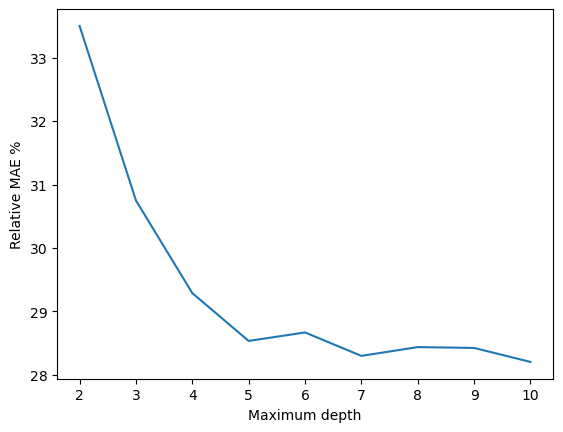

In [21]:
plt.plot(range(2, 11), mae_rf["Viedenska"])

plt.xlabel("Maximum depth")
plt.ylabel("Relative MAE %")